Zeromode方程式を解こう！
========================

概要
---------
「Mastering Modern Conception of Quantum Field Theory : 第3章 ゼロモード」にある数値計算の解説. そんなに難しくないように見えて割と落とし穴があるので注意. 

In [2]:
# Jupyterの(ry
%matplotlib inline

# coding: utf-8

import numpy as np
from scipy import linalg
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sbn
from abc import abstractmethod, ABCMeta

Import
----------------
### `scipy.optimize`
数値最適化に関するライブラリ. 今回は２分法`bisect()`を使っています. 他にもいろいろあって, 最急降下法チックなやつとかSteffensenの反復法とか. 

### `abc`
Pythonの抽象クラスライブラリ. 実はPythonの仕様には元々抽象クラスはない. 今回はオブジェクト指向で書くことにしました. 

In [3]:
# --*-- Constants' and variables' class --*--

class Variables():
    def __init__(self, N):
        # -*- Constants on real space -*-
        
        # Particle number
        self.N = N
        # Volume
        self.V = 1
        # Interaction constant
        self.g = 1e-3
        # Integrals for oder parameter and ajoint parameter
        self.A = self.g*self.N**2/self.V
        self.B = self.g*self.N/self.V/2
        self.C = self.g/self.V/4
        self.D = self.g/self.V/self.N/8
        self.E = self.g/self.V/self.N**2/16
        self.I = self.g/self.V
    
        # -*- Constant on Zeromode space -*-

        # Volume of Zeromode q-space
        self.L = 20*(self.N*self.V)**(-1/3)
        # Step numbers of Zeromode q-space
        self.Nq = 200
        # Step size of Zeromode q-space
        self.dq = self.L/self.Nq
        # Zeromode q-space coordinate
        self.q = np.arange(self.Nq)

Variables class
----------------
物理量や系の分割数など. 取り扱う変数が多く, かつどのメソッドがどの変数を要求するのかを把握することが(いずれ有限温度系に拡張すると)困難になる(と思われる)ので, Variablesクラスのインスタンスを参照でブン投げてたらい回しにします. メソッドの引数がシンプルになります. 
### `N`, `V`, `g`
粒子数, 体積, 相互作用定数. 一様系でかつ粒子数が多い場合を相手にしなければならないので, `N`はVよりも大きめに取るのが良い. さもなくば
$$
<\Psi| Q^2 |\Psi> \simeq N^{-\frac{1}{3}}
$$
が成り立たず, `Q^2`が凝縮体の位相を記述できなくなる. 
どれくらいの値が良いのかは正直あまりよくわからない. ただ物理的にマズい値は取らないようにしましょう(相互作用がでかいとか, `N`が小さいとか). Self-consistentループが収束しない可能性があります. 
### `A`, `B`, `C`, `D`, `E`, `I`
`A`〜`E`は秩序パラメータ・共役パラメータの積分. `I`は共役モードの規格化因子. 詳細は省略. 
### `L, Nq, dq, q`
`L`はゼロモード空間のサイズ. 注意しなければならないのは系の体積`V`とは別物であるということ. そもそも真空は
$$
|0> = |0>_{ex} \otimes |\Psi>
$$
のようにBdGモードが作る真空とゼロモードが作る真空の直積になっており, それぞれは全くの別物. というわけで`L`はゼロモード空間の`q`-表示
$$
\Psi(q) = < q|\Psi>
$$
の体積です. 系が3次元になろうとも, ゼロモード空間は1次元のままです. `Nq`, `dq`, `q`はなんとなくわかるでしょう. `L`のサイズ選び方については後述. 

In [4]:
# --*-- Basis class --*--
class Procedures(metaclass=ABCMeta):
    
    # Make Zeromode hamiltonian(Lower triangle)
    def __MakeZeromodeHamiltonian(self, v, dmu):

        alpha = 3*v.E/v.dq**4 + (v.I -4*v.D)/v.dq**2 + 2*v.C*(v.q-v.Nq/2.0)**2 -2*v.dq**2*v.B*(v.q-v.Nq/2.0)**2 + 0.5*v.dq**4*v.A*(v.q-v.Nq/2.0)**4
        beta = -2*v.E/v.dq**4 + 2.0j*v.D/v.dq**3 - 0.5*(v.I - 4*v.D)/v.dq**2 - 0.5j*(dmu + 4*v.C)/v.dq - (v.C - 1j*v.dq*v.B)*(v.q-v.Nq/2)*(v.q-v.Nq/2+1)
        gamma = [0.5*v.E/v.dq**4 - 1j*v.D/v.dq**3]*v.Nq
    
        return np.vstack((np.vstack((alpha, beta)), gamma))

    
    # Solve eigenvalue problem for Zeromode hamiltonian
    def ZeromodeEquation(self, v, dmu):
        Hqp = self.__MakeZeromodeHamiltonian(v, dmu)
        # Only ground state
        w, val = linalg.eig_banded(Hqp, lower=True, select="i", select_range=(0, 0), overwrite_a_band=True)
        val = val.reshape(v.Nq)
        
        return val

    
    # Output expected value of Zeromode operator P
    def OutputP(self, v, dmu):
        val = self.ZeromodeEquation(v, dmu)

        # Check boundary value of Zeromode q-space
        if(np.abs(val[0]) > 0.01):
            print("warning!!!")
        
        return np.imag(np.dot(np.conj(val[:-1]),val[1:]))/v.dq

    
    # Find proper counter term dmu
    def SelfConsistent(self, v):
        dmu = optimize.bisect(lambda pro_dmu : self.OutputP(v, pro_dmu), -1, 1)
        
        return dmu


    def SetPlot(self, plot_x, plot_y, xlim=False, ylim=False, logscale_x=False, logscale_y=False, xlabel=False, ylabel=False, title=False):
        plt.plot(plot_x, plot_y)
        if(title):
            plt.title(title)
        if(xlabel):
            plt.xlabel(xlabel)
        if(ylabel):
            plt.ylabel(ylabel)
        if(xlim):
            plt.xlim(xlim[0], xlim[1])
        if(ylim):
            plt.ylim(ylim[0], ylim[1])
        if(logscale_x):
            plt.xscale("log")
        if(logscale_y):
            plt.yscale("log")
            
        plt.show()

    # Use this method with inheritance
    @abstractmethod
    def Procedure(self, N):
        pass

Procedures class
-----------------
このクラスは`ABCmeta`を継承している抽象クラスです. つまりこいつは単体で呼ばずに継承して呼ぶことになります. このあとで物理量を計算するクラスを作りますが, そいつらはみんなこのクラスを継承することになります. 
### __MakeZeromodeHamiltonian()
ゼロモードハミルトニアンを作る. あとで`linalg.eig_banded` に`Lower`で格納するので, 「Matering...」にあるα, β, γの複素共役をとっていることに注意. 格納の方法は見たまんまですが, もしよくわからなければSciPyのマニュアルを参考にしてください. 
```
lower form:
a00 a11 a22 a33 a44 a55
a10 a21 a32 a43 a54 *
a20 a31 a42 a53 *   *
```
こんなかんじ. ちなみにこのメソッドは直に呼ばずに他のメンバ関数を通して呼ばれるので, 名前の先頭にアンスコ2つ(__)つけてPrivateにしています. 

`q`の意味に注意してください. `q`は`q`-空間の長さの次元を持つものではなく, どちらかというと分割のインデックスにあたります. 是非しっかりと「Mastering...」の計算を追って意味を確認してください. 

### ZeromodeEquation()
ゼロモード方程式を解いて固有ベクトルを(今回はいらないけど固有値も)求めています. もしももっと速度が欲しければ`scipy.sparse.linalg` を使うといいと思います. ARPACKのラッパーなので超速いと思います. 

### OutputP()
内部で`ZeromodeEquation()`を回して固有状態を求め, それを使ってPの期待値を求めます. ここでは一応固有ベクトルの境界値チェックをしています. これも後述. 

### SelfConsistent()
分割条件を満たすためにはPの期待値がゼロにならなければいけないので`OutputP()`を二分法`optimize.bisect()`に渡してPの期待値がゼロになる`dmu`を探します. 二分法の幅は適当に設定しています. だいたいゼロ付近にあります(雑).  

### SetPlot()
プロット用の関数です. 省略. 

### Procedure()
今後このクラスを継承するときは`Procedure()`をオーバーライドしてください, ということです. つまり, `Q2`を求めるクラスも, ゼロモード固有関数を求めるクラスも, みんな`Procedure()`という名前の関数を持っていることになります. 

In [5]:
class OutputP_Mu(Procedures):

    # Set range of dmu
    def __init__(self, start=-0.5, end=0.5):
        self.start = start
        self.end = end

    def Procedure(self, N):
        v = Variables(N)
        ans = []
        ran = [self.start, self.end]
        for n, dmu in enumerate(np.linspace(ran[0], ran[1], 1000)):
            ans.append(self.OutputP(v, dmu))
            #print(n, ", ", end="", flush=True)

        self.SetPlot(plot_x=np.linspace(ran[0], ran[1], 1000), plot_y=ans, xlim=ran, xlabel="dμ", ylabel="P", title="Expected value P for counter term dμ")

        
class OutputZeromodeGroundFunction(Procedures):

    # Set free pro_dmu
    def __init__(self, pro_dmu=False):
        self.pro_dmu = pro_dmu
        
    def Procedure(self, N):
        v = Variables(N)
        if(self.pro_dmu):
            dmu = self.pro_dmu
        else:
            dmu = self.SelfConsistent(v)
        val = self.ZeromodeEquation(v, dmu)

        self.SetPlot(plot_x=v.q, plot_y=np.abs(val), xlabel="q", ylabel="Psi_0", title="Zeromode ground function for a dmu")

        
class OutputQ2_N(Procedures):

    # Set range of N which is power of 10 (like 10^N)
    def __init__(self, N_start=2, N_end=4):
        self.N_start = N_start
        self.N_end = N_end
    
    def Procedure(self, N=None):
        arr_Q2 = []
        arr_N = np.logspace(self.N_start, self.N_end, num=100)
        for N in arr_N:
            v = Variables(N)
            dmu = self.SelfConsistent(v)
            val = self.ZeromodeEquation(v, dmu)
            #print("N = {1}, dmu = {0}".format(dmu, N))
            arr_Q2.append(np.sqrt(v.dq**2*(np.sum(np.abs((v.q-v.Nq/2)*val)**2))))

        self.SetPlot(plot_x=arr_N, plot_y=arr_Q2, xlim=(arr_N[0], arr_N[-1]), ylim=(0.01, 1), logscale_x=True, logscale_y=True, xlabel="N", ylabel="Q^2", title="Expected value Q^2 for N")

OutputP_Mu　class
-------------------------
`dmu`に対する`P`を出力します. 先ほど`bisect`で探索範囲を雑に指定しましたが, 全く適当というわけではないです. OutputP_Mu.Procedure()でグラフを描いてあたりをつけています. 

OutputZeromodeGroundFunction class
----------------------------------
ゼロモード基底関数を出力します. dmuは自分で適当な値を与えることも, on-shellのdmuを選ぶこともできます. 

OutputQ2_N class
-------------------------
粒子数Nに対するQ2の期待値を出力します. 


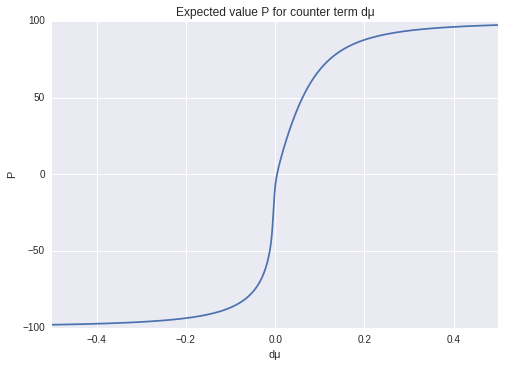

In [6]:
PMu = OutputP_Mu()
PMu.Procedure(N=1e3)

dmu-Pグラフを出力してみました. 原点付近に`P=0`のポイントが見つかるでしょう. これなら[-1, 1]よりももっと狭い範囲を用意しても良さそうです

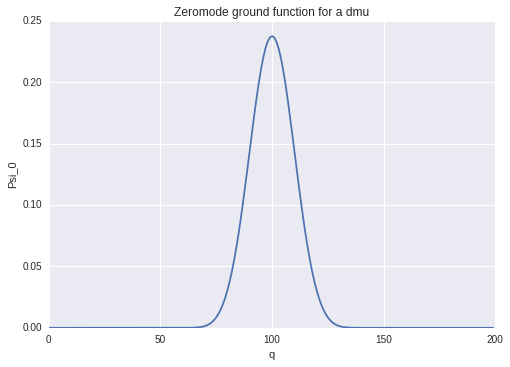

In [8]:
Zero = OutputZeromodeGroundFunction()
Zero.Procedure(N=1e7)

ゼロモード固有関数を出力しました. ガウシアンっぽいグラフが出力されていることがわかります. 「Mastering...」にあるとおり, Leading termが
$$
H_{Lead} = \frac{1}{2}IP^2 + \frac{1}{4}AQ^4
$$
であるのでよい結果といえるでしょう. ゼロモード空間の幅も十分に取れていることがわかります. 

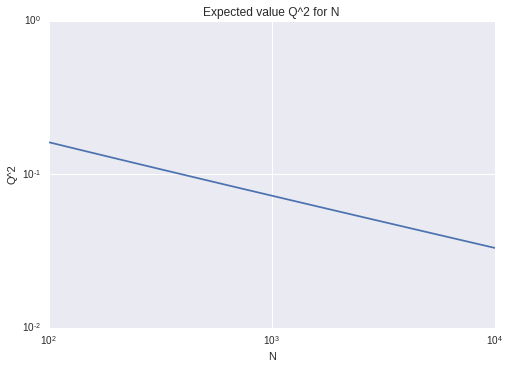

In [13]:
Q2 = OutputQ2_N()
Q2.Procedure()

この結果は鳥居の卒論の結果を再現しています. 傾きは`-1/3`くらいなのでよい結果です. 

Note
-------------------
・鳥居の卒論ではゼロモード演算子を用いてFock空間(もちろん, ゼロモードハミルトニアンの固有状態ではない)を構成し, 粒子数状態で行列表示して計算しています. そんなに難しくないので, 誰か粒子数状態で計算してみてください. 

・ゼロモードの奇数次を含まない定式化ではdmuが現れないのでSelf-consistentループを回す必要がないので計算が非常に簡単になります. 簡単なのでだれかやってみてください. 上の結果が再現されることを願っております. 

Hint
-------------
### ゼロモード固有関数
先程は「ガウシアンっぽい...」と書きましたが, もちろん正確なガウシアンではありません. リーディングな項が`Q`の4乗であればガウシアンっぽくなるでしょう, ということに過ぎません. 逆に言えば, `A`〜`E`及び`I`のパラメータの大小によっては効いてくる項が代わり, 全くガウシアンに似ていないグラフが出力される可能性もあるということです. 例えば...

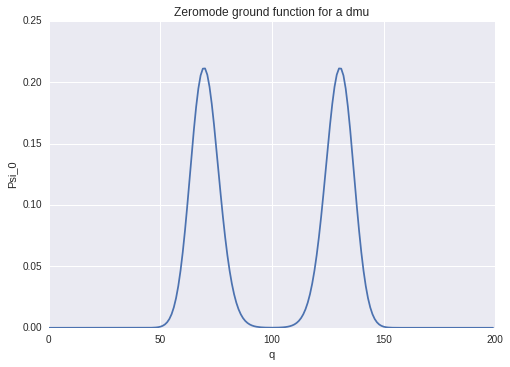

In [40]:
Zero = OutputZeromodeGroundFunction(pro_dmu=-1)
Zero.Procedure(N=1e4)

みたいな. もちろんこれは`on-shell`のdmuでこのような固有関数が出てくるかどうかはわかりません. ゼロモードの総合不安定性解析をやる人は少し気にすべきことかもしれません.

### ゼロモード空間のサイズ
ゼロモード固有関数の幅は, もしこれをガウシアンみたいなものだと思えば`Q2`のサイズに比例するので`N`の`-1/3`乗のオーダーを持ちます. それを見越して`L`の設定をしました. もちろん`N`の値によって`L`も変更されるべきなので`N`を変更するごとにVariablesのインスタンスも再生成しています. 

ここで, もう少し小さく, かつ`N`に対して動的に変更しないような`L`を選択してしまったとしましょう:

In [30]:
# --*-- Constants' and variables' class --*--

class Variables():
    def __init__(self, N):
        # -*- Constants on real space -*-
        
        # Particle number
        self.N = N
        # Volume
        self.V = 1
        # Interaction constant
        self.g = 1e-3
        # Integrals for oder parameter and ajoint parameter
        self.A = self.g*self.N**2/self.V
        self.B = self.g*self.N/self.V/2
        self.C = self.g/self.V/4
        self.D = self.g/self.V/self.N/8
        self.E = self.g/self.V/self.N**2/16
        self.I = self.g/self.V
    
        # -*- Constant on Zeromode space -*-

        # Volume of Zeromode q-space
        self.L = 0.1 # Small and fixed
        # Step numbers of Zeromode q-space
        self.Nq = 200
        # Step size of Zeromode q-space
        self.dq = self.L/self.Nq
        # Zeromode q-space coordinate
        self.q = np.arange(self.Nq)

このとき`Psi`は

warning!!!


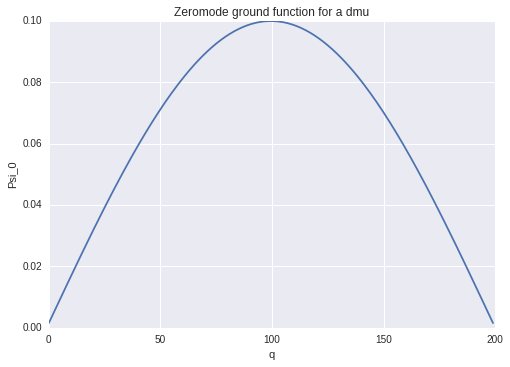

In [31]:
Zero = OutputZeromodeGroundFunction()
Zero.Procedure(N=1e4)

のように窮屈な形になってしまいます. これはあまりよい系の選び方とは言えないでしょう.

さらに次は`V, g`を変更したこんな系を用意します:

In [32]:
# --*-- Constants' and variables' class --*--

class Variables():
    def __init__(self, N):
        # -*- Constants on real space -*-
        
        # Particle number
        self.N = N
        # Volume
        self.V = 1e4
        # Interaction constant
        self.g = 1e-6
        # Integrals for oder parameter and ajoint parameter
        self.A = self.g*self.N**2/self.V
        self.B = self.g*self.N/self.V/2
        self.C = self.g/self.V/4
        self.D = self.g/self.V/self.N/8
        self.E = self.g/self.V/self.N**2/16
        self.I = self.g/self.V
    
        # -*- Constant on Zeromode space -*-

        # Volume of Zeromode q-space
        self.L = 1
        # Step numbers of Zeromode q-space
        self.Nq = 100
        # Step size of Zeromode q-space
        self.dq = self.L/self.Nq
        # Zeromode q-space coordinate
        self.q = np.arange(self.Nq)

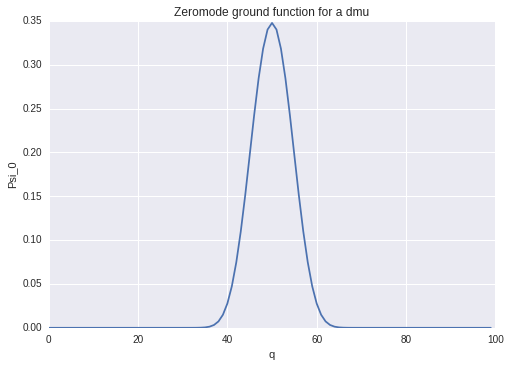

In [35]:
Zero = OutputZeromodeGroundFunction()
Zero.Procedure(N=1e4)

ゼロモード基底状態は悪くなさそうですが...

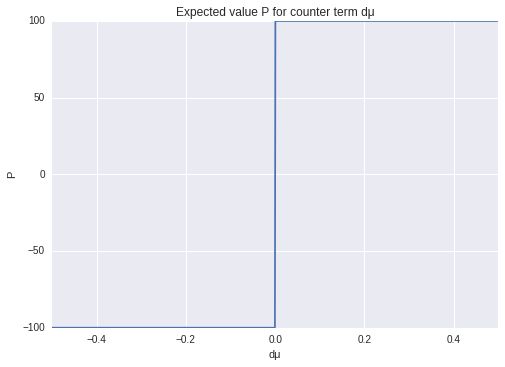

In [36]:
PMu = OutputP_Mu()
PMu.Procedure(N=1e4)

`dmu-P`グラフの動きがピーキー過ぎてヤバイです. これでは適切な`dmu`が選択できているか怪しいものです.

このように各グラフはパラメーターの選び方に強く依存し, また適切なパラメーターを選択することはそんなに簡単なことではないです. このようなグラフを常に観察してよいパラメーターを選択しましょう. 